## Computer Vision Classification 

##  Get Data Ready

In [1]:
# Import Pytorch
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as ToTensor
from torchvision import datasets
from torchvision import transforms 
import matplotlib.pyplot as plt
import numpy as np  
print(torch.__version__)
print(torchvision.__version__)
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

2.9.1+cpu
0.24.1+cpu
Using device: cpu


In [2]:
## 1. Load Dataset
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download = True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download = True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

In [3]:
print(len(train_data),len(test_data))
image,label = train_data[0]

60000 10000


In [4]:
class_names= train_data.classes
print(class_names)
class_to_idx = train_data.class_to_idx
print(class_to_idx)
print(image.shape,label)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
{'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}
torch.Size([1, 28, 28]) 9


Image shape: torch.Size([1, 28, 28])


Text(0.5, 1.0, 'Ankle boot')

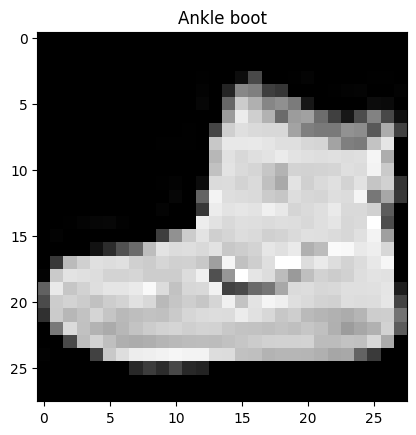

In [5]:
image,label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze(),cmap="gray")
plt.title(class_names[label])

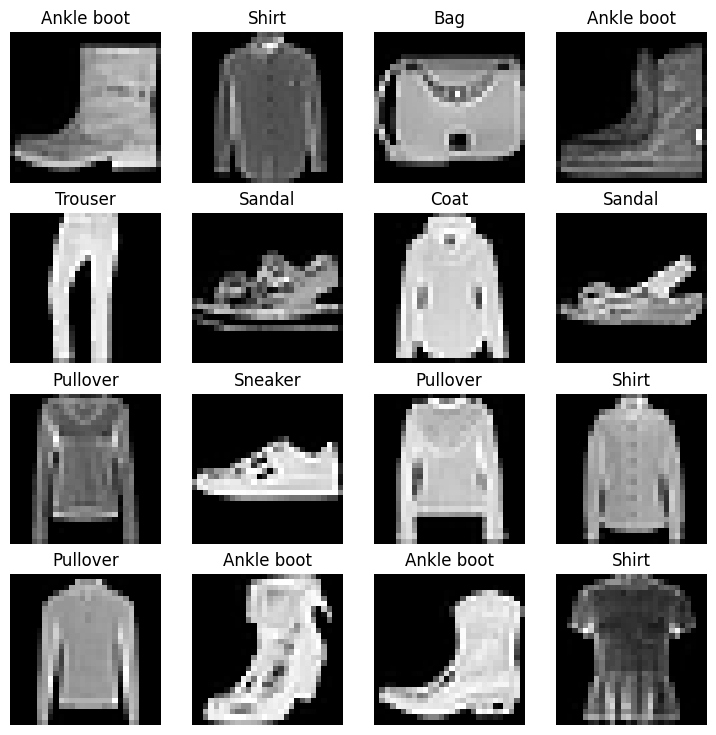

In [6]:
# Plot more
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows ,cols = 4,4
for i in range(1,rows*cols+1):
    random_idx = torch.randint(0,len(train_data),size=[1]).item()
    img , label =  train_data[random_idx]
    fig.add_subplot(rows,cols,i)
    plt.imshow(img.squeeze(),cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

In [7]:
## 2. Create DataLoader
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)
test_dataloader = DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=False)

In [8]:
print(f"Dataloader: {train_dataloader}, batches of {BATCH_SIZE}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloader: <torch.utils.data.dataloader.DataLoader object at 0x000001B870005940>, batches of 32
Length of train_dataloader: 1875 batches of 32
Length of test_dataloader: 313 batches of 32


torch.Size([32, 1, 28, 28])


Text(0.5, 1.0, 'Sandal')

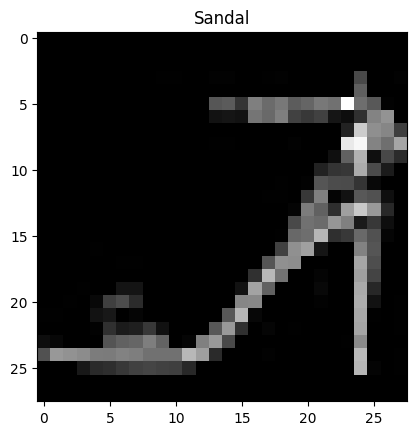

In [9]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
print(train_features_batch.shape)
plt.imshow(train_features_batch[0].squeeze(), cmap="gray")
plt.title(class_names[train_labels_batch[0]])


## Build a baseline model

In [10]:
## flatten layer
flatten_layer = nn.Flatten()
# Get a single sample
x = train_features_batch[0]
# Flatten it
output = flatten_layer(x) # Perform the forward pass

# Print 
print(f"Original shape: {x.shape} -> Flattened shape: {output.shape}")

Original shape: torch.Size([1, 28, 28]) -> Flattened shape: torch.Size([1, 784])


In [11]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
    def __init__(self,input_shape:int,hidden_units:int,output_shape:int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,out_features=hidden_units),
            # nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_shape),
        )
        
    def forward(self,x):
        return self.layer_stack(x)

In [12]:
torch.manual_seed(42)

# Setup model with input parameters
model_0 = FashionMNISTModelV0(
    input_shape=784,
    hidden_units=10,
    output_shape=len(class_names)
).to(device)

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [13]:
dummy_x = torch.rand([1,1,28,28])
model_0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

In [14]:
def accuracy_fn(y_true,y_preds):
    correct = torch.eq(y_true,y_preds).sum().item()
    acc = (correct / len(y_preds)) * 100
    return acc


In [15]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),lr=0.1)

In [16]:
# Create a function to time our model
from timeit import default_timer as timer
def print_train_time(start:float,end:float,device: torch.device = None):
    """Prints differnce between start and end time"""
    total_time = end-start
    print(f"Train Time on {device} is {total_time} sec")
    return total_time

In [17]:
start_time = timer()

end_time = timer()
print_train_time(start=start_time,end=end_time,device=device)

Train Time on cpu is 5.2800000048591755e-05 sec


5.2800000048591755e-05

In [18]:
from tqdm.auto import tqdm

c:\dev\personal\LLMProjects\PyTorchLearn\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Train the Model
epochs = 3
# The optmizer will update gradients  will update once per batch not per epoch
# Create a Training Loop and Testing Loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-----")
    # Training 
    train_loss = 0
    # Add a loop to loop through the training batch
    for batch, (X,y) in enumerate(train_dataloader):
        model_0.train()
        # 1. Forward Pass
        y_pred = model_0(X)
        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred,y)
        train_loss += loss
        # 3. Optimizer zero_grad
        optimizer.zero_grad()
        # 4. Loss Backwards
        loss.backward()
        # 5. Optimizer step
        optimizer.step()
    
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")
    
    # Divide total train loss by length of train dataloader
    train_loss /= len(train_dataloader)
    
    # Testing
    test_loss,test_acc = 0,0
    model_0.eval()
    with torch.inference_mode():
        for X,y in test_dataloader:
            # 1. Forward pass
            test_pred = model_0(X)
            # 2. Calculate loss (accumulatively)
            test_loss += loss_fn(test_pred,y)
            # 3. Calculate accuracy
            test_acc += accuracy_fn(y_true=y, y_preds=test_pred.argmax(dim=1))
        # Calculate the test loss avg per batch
        test_loss /= len(test_dataloader)
        
#  Print out what's happening
    print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc/len(test_dataloader):.2f}%\n")

# Calcute the total time
train_time_end_on_cpu = timer()
total_train_time_model_0_on_cpu = print_train_time(start=train_time_start_on_cpu,
                                                    end=train_time_end_on_cpu,
                                                    device=device)
print(f"Total Training Timee = {total_train_time_model_0_on_cpu}")
    

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-----
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 33%|███▎      | 1/3 [00:06<00:12,  6.21s/it]

Epoch: 0 | Train Loss: 0.5904 | Test Loss: 0.5095 | Test Acc: 82.04%

Epoch: 1
-----
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 67%|██████▋   | 2/3 [00:12<00:06,  6.23s/it]

Epoch: 1 | Train Loss: 0.4763 | Test Loss: 0.4799 | Test Acc: 83.20%

Epoch: 2
-----
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


100%|██████████| 3/3 [00:18<00:00,  6.33s/it]

Epoch: 2 | Train Loss: 0.4550 | Test Loss: 0.4766 | Test Acc: 83.43%

Train Time on cpu is 18.994237700000667 sec
Total Training Timee = 18.994237700000667


In [20]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    """Returns a dictionary of model results on a data loader"""
    loss, acc = 0,0
    model.eval()
    with torch.inference_mode():
        for X,y in tqdm(data_loader):
            # 1. Forward pass
            test_pred = model(X)
            # 2. Calculate loss (accumulatively)
            loss += loss_fn(test_pred,y)
            # 3. Calculate accuracy
            acc += accuracy_fn(y_true=y, y_preds=test_pred.argmax(dim=1))
        # Calculate the test loss avg per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}

In [21]:
# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model_0,
                              data_loader=test_dataloader,
                              loss_fn=loss_fn,
                              accuracy_fn=accuracy_fn)
model_0_results

100%|██████████| 313/313 [00:01<00:00, 295.67it/s]


{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.4766388535499573,
 'model_acc': 83.42651757188499}

## Creating a Better Model , With Non-Linearity

In [22]:
## flatten layer
flatten_layer = nn.Flatten()
# Get a single sample
x = train_features_batch[0]
# Flatten it
output = flatten_layer(x) # Perform the forward pass

# Print 
print(f"Original shape: {x.shape} -> Flattened shape: {output.shape}")

Original shape: torch.Size([1, 28, 28]) -> Flattened shape: torch.Size([1, 784])


In [23]:
# New model with more layers and non-linear activations
class FashionMNISTModelV1(nn.Module):
    def __init__(self,input_shape:int,hidden_units:int,output_shape:int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units,out_features=output_shape),
        )
        
    def forward(self,x):
        return self.layer_stack(x)

In [24]:
torch.manual_seed(42)

# Setup model with input parameters
model_1 = FashionMNISTModelV1(
    input_shape=784,
    hidden_units=10,
    output_shape=len(class_names)
).to(device)

model_1

FashionMNISTModelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
    (5): Linear(in_features=10, out_features=10, bias=True)
    (6): ReLU()
    (7): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [25]:
# Train the model
def Training_The_Model(model=model_1,epochs=epochs):
    # Create optimizer for This model
    optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
    loss_fn = nn.CrossEntropyLoss()
    # Set the seed and start the timer
    torch.manual_seed(42)
    train_time_start_on_cpu = timer()


    # The optmizer will update gradients  will update once per batch not per epoch
    # Create a Training Loop and Testing Loop
    for epoch in tqdm(range(epochs)):
        print(f"Epoch: {epoch}\n")
        # Training 
        train_loss = 0
        # Add a loop to loop through the training batch
        for batch, (X,y) in enumerate(train_dataloader):
            model.train()
            # 1. Forward Pass
            y_pred = model(X)
            # 2. Calculate loss (per batch)
            loss = loss_fn(y_pred,y)
            train_loss += loss
            # 3. Optimizer zero_grad
            optimizer.zero_grad()
            # 4. Loss Backwards
            loss.backward()
            # 5. Optimizer step
            optimizer.step()
        
            if batch % 400 == 0:
                print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")
        
        # Divide total train loss by length of train dataloader
        train_loss /= len(train_dataloader)
        
        # Testing
        test_loss,test_acc = 0,0
        model.eval()
        with torch.inference_mode():
            for X,y in test_dataloader:
                # 1. Forward pass
                test_pred = model(X)
                # 2. Calculate loss (accumulatively)
                test_loss += loss_fn(test_pred,y)
                # 3. Calculate accuracy
                test_acc += accuracy_fn(y_true=y, y_preds=test_pred.argmax(dim=1))
            # Calculate the test loss avg per batch
            test_loss /= len(test_dataloader)
            
    #  Print out what's happening
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc/len(test_dataloader):.2f}%\n")

    # Calcute the total time
    train_time_end_on_cpu = timer()
    total_train_time_model_on_cpu = print_train_time(start=train_time_start_on_cpu,
                                                        end=train_time_end_on_cpu,
                                                        device=device)
    print(f"Total Training Timee = {total_train_time_model_on_cpu}")

In [26]:
# Evaluate the model
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    """Returns a dictionary of model results on a data loader"""
    loss, acc = 0,0
    model.eval()
    with torch.inference_mode():
        for X,y in tqdm(data_loader):
            # 1. Forward pass
            test_pred = model(X)
            # 2. Calculate loss (accumulatively)
            loss += loss_fn(test_pred,y)
            # 3. Calculate accuracy
            acc += accuracy_fn(y_true=y, y_preds=test_pred.argmax(dim=1))
        # Calculate the test loss avg per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}

In [27]:
# Training_The_Model
Training_The_Model(model=model_1,epochs=3)

# Calculate model 1 results on test dataset
model_1_results = eval_model(model=model_1,
                              data_loader=test_dataloader,
                              loss_fn=loss_fn,
                              accuracy_fn=accuracy_fn)

# Print the result
model_1_results

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0

Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 33%|███▎      | 1/3 [00:08<00:16,  8.08s/it]

Epoch: 0 | Train Loss: 0.8364 | Test Loss: 0.5901 | Test Acc: 76.89%

Epoch: 1

Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 67%|██████▋   | 2/3 [00:15<00:07,  7.84s/it]

Epoch: 1 | Train Loss: 0.5526 | Test Loss: 0.5757 | Test Acc: 79.38%

Epoch: 2

Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


100%|██████████| 3/3 [00:23<00:00,  7.85s/it]


Epoch: 2 | Train Loss: 0.4976 | Test Loss: 0.5209 | Test Acc: 81.74%

Train Time on cpu is 23.54471779999949 sec
Total Training Timee = 23.54471779999949


100%|██████████| 313/313 [00:01<00:00, 284.98it/s]


{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.5209097862243652,
 'model_acc': 81.73921725239616}

In [28]:
print(f"Model 0 :{model_0_results}\nModel 1 :{model_1_results}")

Model 0 :{'model_name': 'FashionMNISTModelV0', 'model_loss': 0.4766388535499573, 'model_acc': 83.42651757188499}
Model 1 :{'model_name': 'FashionMNISTModelV1', 'model_loss': 0.5209097862243652, 'model_acc': 81.73921725239616}


## Building a CNN

In [29]:
class FashionMNISTModelV2(nn.Module):
    """ CNN Architecture"""
    def __init__(self,input_shape: int, output_shape: int, hidden_units: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)   
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)   
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )
        
    def forward(self,x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

In [30]:
torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)
model_2.state_dict()

OrderedDict([('conv_block_1.0.weight',
              tensor([[[[ 0.2548,  0.2767, -0.0781],
                        [ 0.3062, -0.0730,  0.0673],
                        [-0.1623,  0.1958,  0.2938]]],
              
              
                      [[[-0.2445,  0.2897,  0.0624],
                        [ 0.2463,  0.0451,  0.1607],
                        [-0.0471,  0.2570,  0.0493]]],
              
              
                      [[[-0.1556,  0.0850, -0.1536],
                        [-0.0391, -0.1354,  0.2211],
                        [-0.2631, -0.1537, -0.0941]]],
              
              
                      [[[-0.2004,  0.0315, -0.3292],
                        [ 0.3010, -0.2832,  0.2573],
                        [ 0.0555, -0.1082,  0.2060]]],
              
              
                      [[[ 0.0520,  0.2693,  0.0364],
                        [-0.1051,  0.0896, -0.0904],
                        [ 0.1403,  0.2976,  0.1927]]],
              
              
      

In [31]:
torch.manual_seed(42)
images = torch.randn(size=(32,3,64,64))
test_img = images[0]
print(f"Image shape : {test_img.shape}")

Image shape : torch.Size([3, 64, 64])


In [32]:
torch.manual_seed(42)
# Creating a single Conv2d layer
conv2d_layer = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=0)
print("Before runinng:",conv2d_layer.state_dict())
# Let's pass data and see
conv2d_layer_img = conv2d_layer(test_img)
print("After running:",conv2d_layer_img)


Before runinng: OrderedDict({'weight': tensor([[[[ 0.1471,  0.1597, -0.0451],
          [ 0.1768, -0.0422,  0.0388],
          [-0.0937,  0.1130,  0.1697]],

         [[-0.1412,  0.1673,  0.0360],
          [ 0.1422,  0.0261,  0.0928],
          [-0.0272,  0.1484,  0.0284]],

         [[-0.0898,  0.0491, -0.0887],
          [-0.0226, -0.0782,  0.1277],
          [-0.1519, -0.0887, -0.0543]]],


        [[[-0.1157,  0.0182, -0.1901],
          [ 0.1738, -0.1635,  0.1486],
          [ 0.0320, -0.0625,  0.1189]],

         [[ 0.0300,  0.1555,  0.0210],
          [-0.0607,  0.0517, -0.0522],
          [ 0.0810,  0.1718,  0.1112]],

         [[-0.0841,  0.1111,  0.0344],
          [ 0.0977, -0.1173, -0.1905],
          [-0.0744, -0.1476,  0.1579]]],


        [[[ 0.0554,  0.0797,  0.0609],
          [-0.0033,  0.1506, -0.1367],
          [ 0.0121, -0.1314,  0.0593]],

         [[-0.0663,  0.0590, -0.0401],
          [ 0.1596, -0.1141, -0.1148],
          [-0.1148,  0.1731,  0.0641]],

     

In [33]:
print(f"The original shape of the test image: {test_img.shape}")
img_through_conv_layer = conv2d_layer(test_img)
print(f"The Img after conv: {img_through_conv_layer.unsqueeze(0).shape}")
maxpool_layer = nn.MaxPool2d(kernel_size=2) 
maxpool_img = maxpool_layer(img_through_conv_layer)
print(f"The Img after conv and maxpool: {maxpool_img.unsqueeze(0).shape}")

The original shape of the test image: torch.Size([3, 64, 64])
The Img after conv: torch.Size([1, 10, 62, 62])
The Img after conv and maxpool: torch.Size([1, 10, 31, 31])


The Input image shapetorch.Size([32, 1, 28, 28])
The Output shape after model_2:torch.Size([1, 10])


Text(0, 0.5, 'Logit Value')

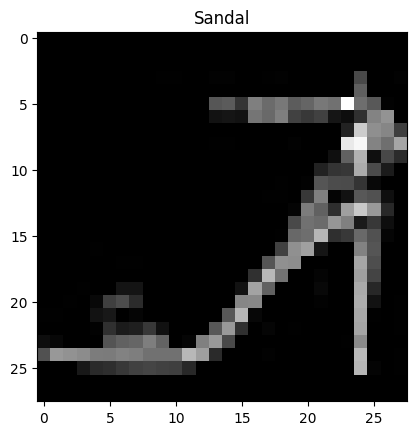

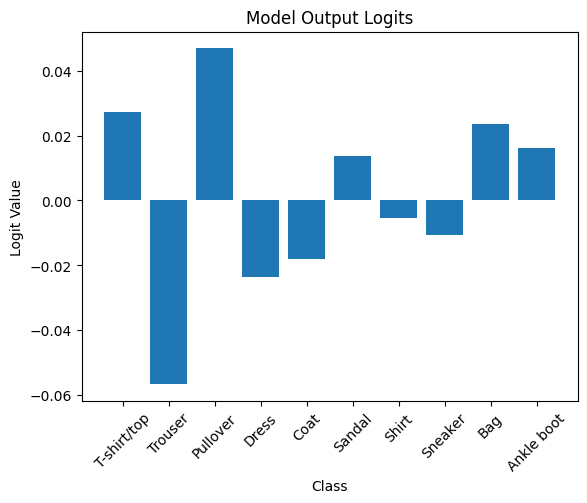

In [34]:
# Images after model_2
print(f"The Input image shape{train_features_batch.shape}")
test_img = train_features_batch[0]
plt.imshow(test_img.squeeze(), cmap="gray")
plt.title(class_names[train_labels_batch[0]])
# Images after model_2
y = model_2(test_img.unsqueeze(0))
print(f"The Output shape after model_2:{y.shape}")
# Plot y 
plt.figure()
plt.bar(range(len(class_names)), y.detach().squeeze())
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.title("Model Output Logits")
plt.xlabel("Class")
plt.ylabel("Logit Value")

In [35]:
# Training_The_Model_2 CNN
Training_The_Model(model=model_2,epochs=3)

# Calculate model 1 results on test dataset
model_2_results = eval_model(model=model_2,
                              data_loader=test_dataloader,
                              loss_fn=loss_fn,
                              accuracy_fn=accuracy_fn)

# Print the result
print(f"Model 0:{model_0_results}\nmodel_1_results:{model_1_results}\nmodel_2_results:{model_2_results}")

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0

Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 33%|███▎      | 1/3 [00:20<00:41, 20.73s/it]

Epoch: 0 | Train Loss: 0.5888 | Test Loss: 0.4053 | Test Acc: 85.24%

Epoch: 1

Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 67%|██████▋   | 2/3 [00:41<00:20, 20.46s/it]

Epoch: 1 | Train Loss: 0.3637 | Test Loss: 0.3571 | Test Acc: 86.99%

Epoch: 2

Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


100%|██████████| 3/3 [01:01<00:00, 20.47s/it]


Epoch: 2 | Train Loss: 0.3253 | Test Loss: 0.3159 | Test Acc: 88.50%

Train Time on cpu is 61.408493899998575 sec
Total Training Timee = 61.408493899998575


100%|██████████| 313/313 [00:01<00:00, 194.05it/s]

Model 0:{'model_name': 'FashionMNISTModelV0', 'model_loss': 0.4766388535499573, 'model_acc': 83.42651757188499}
model_1_results:{'model_name': 'FashionMNISTModelV1', 'model_loss': 0.5209097862243652, 'model_acc': 81.73921725239616}
model_2_results:{'model_name': 'FashionMNISTModelV2', 'model_loss': 0.3159361183643341, 'model_acc': 88.49840255591054}


The Input image shapetorch.Size([32, 1, 28, 28])
The Output shape after model_2:torch.Size([1, 10])


Text(0, 0.5, 'Logit Value')

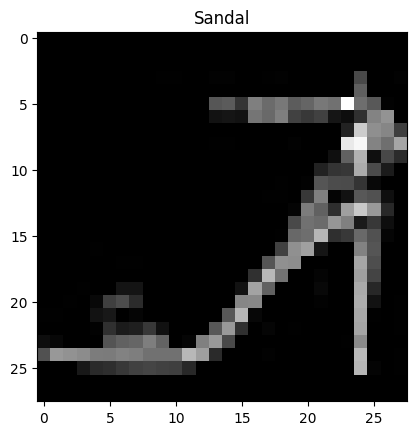

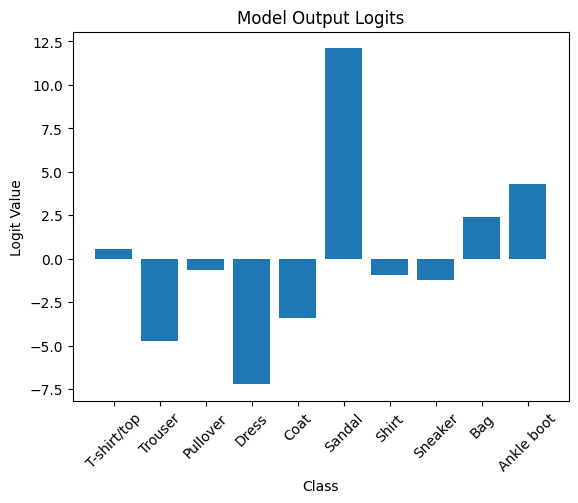

In [36]:
# Images after model_2
print(f"The Input image shape{train_features_batch.shape}")
test_img = train_features_batch[0]
plt.imshow(test_img.squeeze(), cmap="gray")
plt.title(class_names[train_labels_batch[0]])
# Images after model_2
y = model_2(test_img.unsqueeze(0))
print(f"The Output shape after model_2:{y.shape}")
# Plot y 
plt.figure()
plt.bar(range(len(class_names)), y.detach().squeeze())
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.title("Model Output Logits")
plt.xlabel("Class")
plt.ylabel("Logit Value")

In [37]:
def plot_random_predictions(model, dataset, class_names, n_images=9):
    """Plot random images with their predictions and true labels"""
    # torch.manual_seed(42)
    fig = plt.figure(figsize=(12, 12))
    rows, cols = 3, 3
    
    model.eval()
    with torch.inference_mode():
        for i in range(1, n_images + 1):
            # Get random image
            random_idx = torch.randint(0, len(dataset), size=[1]).item()
            img, label = dataset[random_idx]
            
            # Make prediction
            pred_logits = model(img.unsqueeze(0))
            pred_class = pred_logits.argmax(dim=1).item()
            
            # Plot
            fig.add_subplot(rows, cols, i)
            plt.imshow(img.squeeze(), cmap="gray")
            
            # Green if correct, red if wrong
            title_color = "green" if pred_class == label else "red"
            plt.title(f"Pred: {class_names[pred_class]} | Truth: {class_names[label]}", color=title_color)
            plt.axis(False)
    plt.tight_layout()
    plt.show()

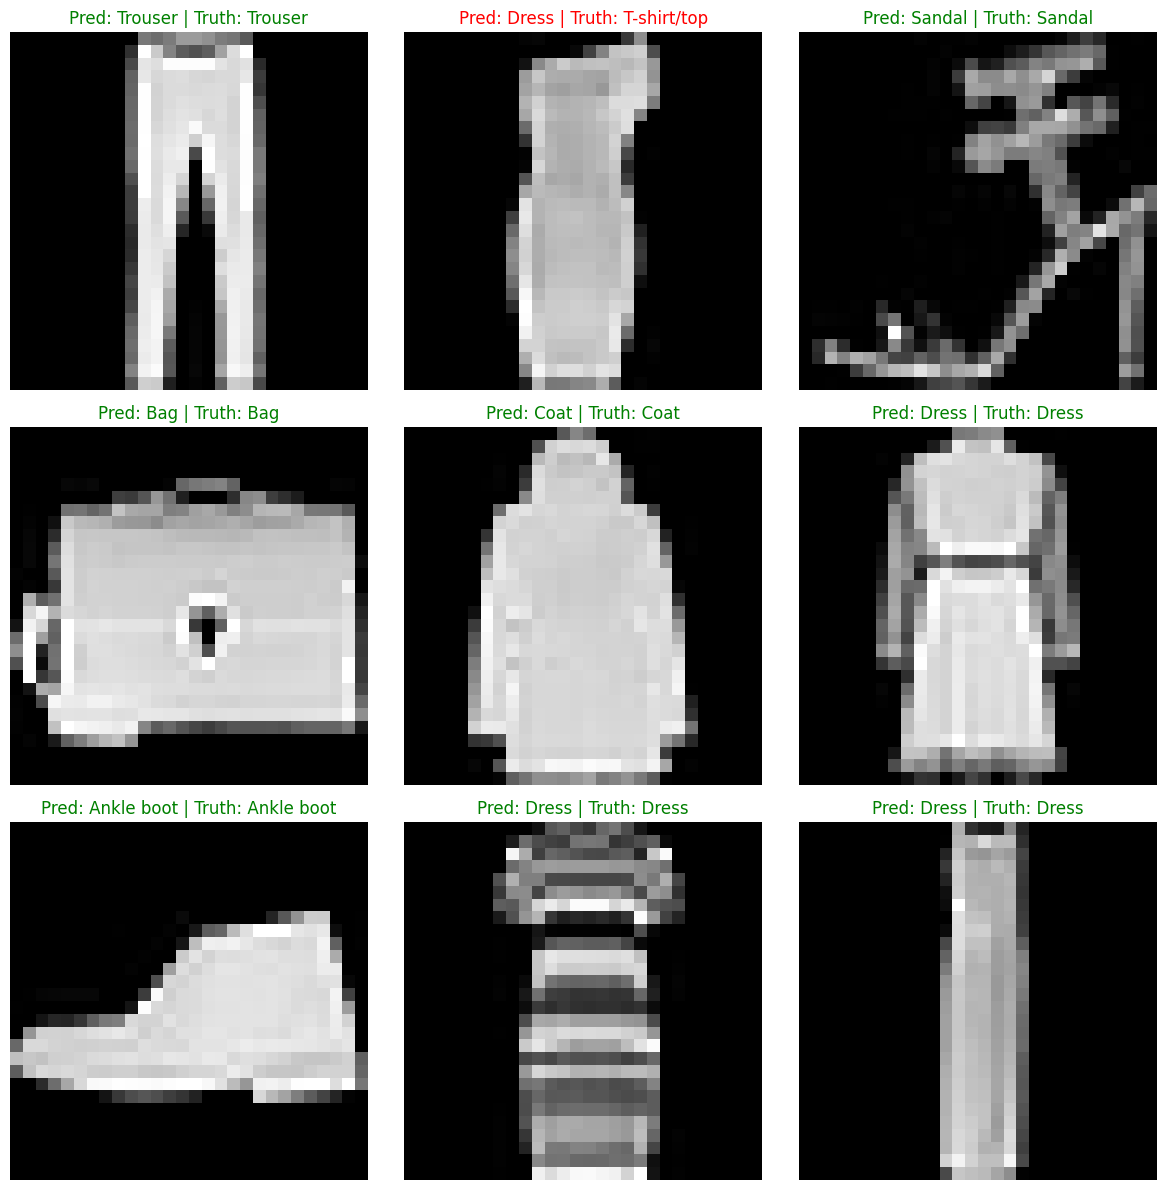

In [38]:
# Call the function
plot_random_predictions(model_2, test_data, class_names, n_images=9)

In [39]:
## Plot confusion matrix
y_preds = []
model_2.eval()
with torch.inference_mode():
    for X,y in tqdm(test_dataloader):
        X,y = X.to(device),y.to(device)
        y_logit = model_2(X)
        y_pred =torch.softmax(y_logit.squeeze(),dim=0).argmax(dim=1)
        y_preds.append(y_pred)

y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:10]

100%|██████████| 313/313 [00:01<00:00, 185.66it/s]


tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

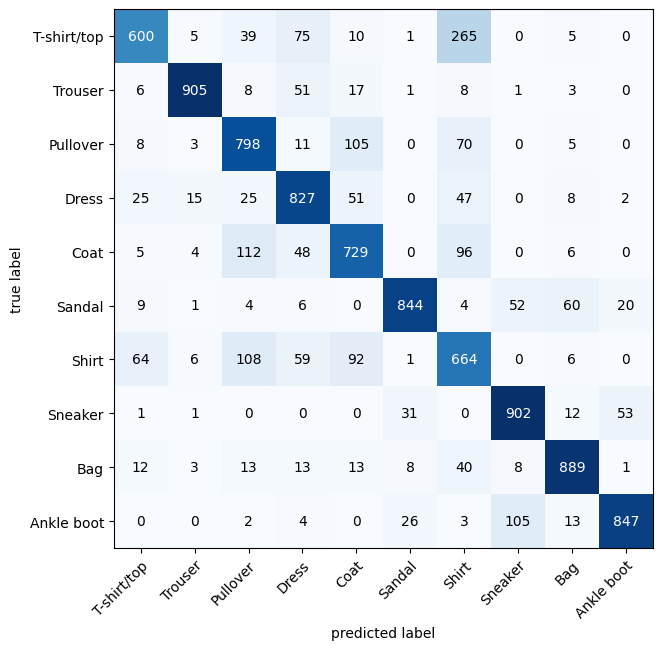

In [41]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
confmat = ConfusionMatrix(task="multiclass",num_classes=len(class_names))
confusion_matrix = confmat(preds=y_pred_tensor,
                           target=test_data.targets)
fx, ax = plot_confusion_matrix(conf_mat=confusion_matrix.numpy(),
                              class_names=class_names,
                                figsize=(10,7))

In [42]:
from pathlib import Path

# Save the model

# Create models directory if it doesn't exist
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create model save path
MODEL_NAME = "fashion_mnist_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
torch.save(obj=model_2.state_dict(), f=MODEL_SAVE_PATH)
print(f"Model saved to: {MODEL_SAVE_PATH}")

Model saved to: models\fashion_mnist_model_2.pth


In [ ]:
# Creata a new instance of the model class
loaded_model_2 = FashionMNISTModelV2(input_shape=1,
                                    hidden_units=10,
                                    output_shape=len(class_names))
loaded_model_2.load_state_dict(torch.load(MODEL_SAVE_PATH))
loaded_model_2.to(device)